In [1]:
import numpy as np
from copy import deepcopy

class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.Z = 0
        self.dA = 0
        self.dW = 0

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        self.Z = deepcopy(X)
        A = np.dot(X, self.W) + self.B
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dA = deepcopy(dA)
        self.dW = np.dot(self.Z.T, dA) / len(self.dA)
        dZ = np.dot(dA, self.W.T) 
        # 更新
        self = self.optimizer.update(self)
        
        return dZ

In [2]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    
    def __init__(self, sigma=0.01):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2=None):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape(n_nodes1, n_nodes2)
        """
        if n_nodes2 is None:
            W = self.sigma * np.random.randn(n_nodes1, 1)
        else:
            W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
            
        return W.astype("f")
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape(1, nodes2)
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B.astype("f")
    
class XavierInitializer:
    """
    Xavierによる初期化
    Sigmoid」かTanhに向いている
    """
    
    def __init__(self):
        self.sigma = None
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape(n_nodes1, n_nodes2)
        """
        self.sigma = 1 / np.sqrt(n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W.astype("f")
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape(1, nodes2)
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B.astype("f")
    
class HeInitializer:
    """
    Heによる初期化
    ReLUと相性がいい
    """
    
    def __init__(self):
        self.sigma = 0
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape(n_nodes1, n_nodes2)
        """
        self.sigma = np.sqrt(2 / n_nodes1)
        W = (self.sigma * np.random.randn(n_nodes1, n_nodes2))
        return W.astype("f")
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape(1, nodes2)
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B.astype("f")

In [3]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        layer.W[...] = layer.W - self.lr * layer.dW
        layer.B[...] = layer.B - self.lr * np.mean(layer.dA, axis=0, keepdims=True)
        return layer

class AdaGrad:
    """
    学習率を変化を減少させていく勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        self.HW = 0
        self.HB = 0
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        
        dW = np.dot(layer.Z.T, layer.dA) / len(layer.dA)
        dB = np.mean(layer.dA, axis=0)
        self.HW += dW**2
        self.HB +=  dB**2
        layer.W[...] = layer.W - self.lr / np.sqrt(self.HW +1e-7) * dW #0で割るとまずいので +le-7
        layer.B[...] = layer.B - self.lr / np.sqrt(self.HB + 1e-7)  * dB
        return layer
    
class Momentum:
    
    """
    momentumSGD
    Parameters
    ----------
    lr : 学習率
    momentum : 学習係数
    """
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.vW = 0
        self.vB = 0
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """

        dW = np.dot(layer.Z.T, layer.dA) / len(layer.dA)
        dB = np.mean(layer.dA, axis=0)
        
        self.vW = self.momentum * self.vW - self.lr * dW
        self.vB =  self.momentum * self.vB - self.lr * dB
        
        layer.W[...] = layer.W + self.vW
        layer.B[...] = layer.B + self.vB
        
        return layer
    
class Adam:

    """
    Adam
    RMSprop に Momentum 法を組み合わせたような形
    Parameters
    ----------
    lr : 学習率
    momentum : 学習係数
    beta1
    beta2
    """

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.mW = 0
        self.vW = 0
        self.mB = 0
        self.vB = 0
        
    def update(self, layer):
        
        self.iter += 1
        dW = np.dot(layer.Z.T, layer.dA) / len(layer.dA)
        dB = np.mean(layer.dA, axis=0)
        
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter) 
        
        self.mW += (1 - self.beta1) * (dW - self.mW)
        self.vW += (1 - self.beta2) * (dW**2 - self.vW)
        self.mB += (1 - self.beta1) * (dB - self.mB)
        self.vB += (1 - self.beta2) * (dB**2 - self.vB)
        
        layer.W -= lr_t * self.mW / (np.sqrt(self.vW) + 1e-7)
        layer.B -= lr_t * self.mB / (np.sqrt(self.vB) + 1e-7)

In [4]:
class sigmoid:
    """
    シグモイド関数
    """
    
    def __init__(self):
        self.Z = 0
    
    def forward(self, A):
        """
        フォワード
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes)
            入力
        Returns
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes)
            出力
        """ 
        Z = 1 / (1 + np.exp(-A))
        self.Z = Z
        return Z
    
    def backward(self, dZ):
        """
        バックワード
        Parameters
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes)
            後ろから流れてきた勾配
        Returns
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes)
            前に流す勾配
        """
        dA = dZ  *  (1 - self.Z) * self.Z 
        return dA
    
class Tanh:
    """
    ハイパボリックタンジェント関数
    """
    
    def __init__(self):
        self.Z = 0
    
    def forward(self, A):
        """
        フォワード
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes)
            入力
        Returns
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes)
            出力
        """ 
        Z = np.tanh(A)
        self.Z = Z
        return Z
    
    def backward(self, dZ):
        """
        バックワード
        Parameters
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes)
            後ろから流れてきた勾配
        Returns
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes)
            前に流す勾配
        """
        dA = dZ  *  (1 - self.Z**2)
        return dA

class Softmax:
    """
    ソフトマックス関数
    """
    
    def __init__(self):
        self.Z = 0
    
    def forward(self, A):
        """
        フォワード
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes)
            入力
        Returns
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes)
            出力
        """ 
        
        c = np.max(A)
        A = A - c
        ex = np.exp(A)
        Z = ex / (np.sum(ex, axis=1))[:, np.newaxis]
        self.Z = Z
        return Z
    
    def backward(self, y):
        """
        バックワード
        Parameters
        ----------
        y : 次の形のndarray, shape (batch_size, n_class)
            正解ラベル
        Returns
        ----------
        dA : 次の形のndarray, shape (batch_size, n_class)
            前に流す勾配
        """
        
        dA = self.Z - y
        
        return dA
    
class ReLU:
    """
    ReLU関数
    """
    
    def __init__(self):
        self.Z = None
    
    def forward(self, A):
        """
        フォワード
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes)
            入力
        Returns
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes)
            出力
        """ 
        Z = np.maximum(0, A)
        self.Z = deepcopy(Z)
        return Z
    
    def backward(self, dZ):
        """
        バックワード
        Parameters
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes)
            後ろから流れてきた勾配
        Returns
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes)
            前に流す勾配
        """
        
        dA = dZ  *  np.where(self.Z != 0, 1, self.Z)
        
        return dA

In [5]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop
    
    #Pythonの特殊メソッドのひとつで、オブジェクトに角括弧でアクセスしたときの挙動を定義できる。
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

In [6]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

class ScratchDeepNeuralNetrowkClassifier2:
    """
    """
    
    def __init__(self, n_features, batch_size=50, epoch=10, verbose=True, metrics="acc"):
        self.n_nodes = [n_features]
        #self.n_output = n_output
        self.batch_size = batch_size
        self.epoch = epoch
        self.metrics = metrics
        self.verbose = verbose
        self.train_loss = []
        self.val_loss = []
        self.layers = []

    
    def add(self, layer_type, n_nodes=None, Initializer=None, optimizer=None):
        
        if layer_type == "FC":
            self.layers += [FC(self.n_nodes[-1], n_nodes, Initializer, optimizer)]
            self.n_nodes += [n_nodes]
            
        elif layer_type == "Conv1d":
            salf.layers += [SimpleConv1d(filter_size=3, in_channel=1, initializer=initializer, optimizer=optimizer, straid=1, pad=0, out_channel=1)]
            self.n_nodes += [n_nodes]
            
        elif layer_type == "ReLU":
            self.layers += [ReLU()]
        
        elif layer_type == "Tanh":
            self.layers += [Tanh()]
        
        elif layer_type == "sigmoid":
            self.layers += [sigmoid()]
            
        elif layer_type == "Softmax":
            self.layers += [Softmax()]
        else:
            print("layer_typeが存在しません")
    
    def add_sim(self, layer):
        
        self.layers += [layer]
            
    def fit(self, X, y, X_val=None, y_val=None, epoch=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        epoch : int
            エポック数変えたいときは入れてください
        """
        if epoch:
            self.epoch = epoch
        
        for i in range(self.epoch):

            #バッチ作成
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=56)

            for mini_X_train, mini_y_train in get_mini_batch:
                
                #FP
                self.FP(mini_X_train)

                #BP
                self.BP(mini_y_train)
                
            #評価値等の表示
            train_pred = self.FP(X)
            self.train_loss += [self._cross_entropy_loss(train_pred, y)]
            
            if np.any(X_val):
                val_pred = self.FP(X_val)
                self.val_loss += [self._cross_entropy_loss(val_pred, y_val)]
                
                #metricsを判定
                if  self.metrics == "acc":
                    met = self.accuracy(np.argmax(y_val, axis=1), np.argmax(val_pred, axis=1))
                else:
                    print("metricsの入力が間違っています")
                      
                if self.verbose:
                    print("epoch:{0} train_loss: {1} val_loss: {2} {3}: {4}".format(i+1, self.train_loss[i], self.val_loss[i], self.metrics, met))
                    
            else:
                if self.verbose:
                      print("epoch:{0} loss: {1}".format(i+1, self.train_loss[i]))
     
    def FP(self, X):
        for layer in self.layers:
            X = layer.forward(X)
            
        return X
            
    def BP(self, y):
        for layer in reversed(self.layers):
            y = layer.backward(y)
    
    def predict(self, X):
        hx = self.FP(X)
        return np.argmax(hx, axis=1)
            
    def _cross_entropy_loss(self,z, y):
        z += 1e-7
        return - sum(sum(y * np.log(z))) / len(y)
    
    def accuracy(self, y, y_pred):
        # accuracyを計算して返す
        return accuracy_score(y, y_pred)
    
    def plot_learning_curve(self):
        """
        学習曲線をプロットします。

        loss : array
        一回ごとの勾配降下方のロスのログ(train)
         val_los : array
        一回ごとの勾配降下方のロスのログ(val or test)
        """
        plt.figure(figsize=(8, 5))
        plt.title("model_loss")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.plot(self.train_loss, label="train_loss")
        plt.plot(self.val_loss, label="val_loss")
        #plt.yscale("log")
        plt.legend()

In [7]:
class SimpleConv1d:
    """
    convolutional layee
    Parameters
    ----------
    filter_size : int
      フィルターのサイズ
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    
    """
    def __init__(self, filter_size, in_channel, initializer, optimizer, straid=1, pad=0, out_channel=1):
        self.optimizer = optimizer
        self.filter_size = filter_size
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(filter_size*in_channel, out_channel) #shape(filter_size*in_channel, out_cannel)
        self.B = initializer.B(out_channel).reshape(1,-1) #shape(1, out_cannel)
        self.out_size = None
        self.out_channel = out_channel
        self.straid = straid
        self.CX = 0
        self.dA = 0 #shape(batch_size, out_size)
        self.dW = 0 
        self.m = 0
        self.n = 0
        self.c = in_channel
        self.pad = pad

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size,  n_feture, n_chanel)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, out_size, out_chanel)
            出力
        """ 
        if X.ndim is 1:
            X = X[np.newaxis, :, np.newaxis]
        elif X.ndim is 2:
            X = X[:, :, np.newaxis]
        self.m = X.shape[0]
        self.n = X.shape[1]
        self.c = X.shape[2]
        #out_sizeの計算
        if self.out_size is None:
            self.out_size = int((self.n + 2*self.pad - self.filter_size) / self.straid + 1)
        
        #並列計算のためXからデータを抜き出す CX shape(out_size*batch_size, filter_size*in_chanel)
        #CX = np.empty((0, self.filter_size*self.c))
        #for i in range(self.m):
            #CX = np.vstack((CX, np.array([X[i, j*self.straid : j*self.straid+self.filter_size, k] for j in range(self.out_size) for k in range(self.c)]).reshape(-1, self.filter_size*self.c)))
        indar = np.array([np.arange(j * self.straid, j*self.straid+self.filter_size) for j in range(self.out_size)])
        #CX = X[:, :, ar].reshape(self.m*self.out_size, self.filter_size) 
        CX = X[:, indar, : ].reshape(self.out_size*self.m, self.filter_size*self.c).astype("f")
        self.CX = CX #shape(self.out_size*self.m, self.filter_size*self.c)
        
        A = np.dot(CX, self.W) + self.B #ここのA shape(batch_size*out_size, out_cahnnel)
        A = A.reshape(self.m, self.out_size, self.out_channel) #ここのA shape(batch_size, out_size, out_cahnnel)
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size,out_size,out_channel)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size,n_feture, in_channel)
            前に流す勾配
        """
        if dA.ndim is 1:
            dA = dA[np.newaxis, :, np.newaxis]
        elif dA.ndim is 2:
            dA = dA[:, :, np.newaxis]
            
        self.dA = np.sum(dA, axis=1)
        self.dW = np.dot(self.CX.T, dA.reshape(-1,self.out_channel)) #dAを shape(out_size*batch_size, out_channel)へ変形
        
        #ここからdZの計算
        #dZの並列計算のためにdAのアレーを作成
        da_ar = np.empty((0, self.filter_size*self.out_channel))
        for i in range(self.m): #サンプル数分ループ
            for j in range(self.n):
                dalist = []
                for k in range(self.out_channel):
                    for s in range(self.filter_size):
                        if  ((j - s) / self.straid < 0) or (j - s > self.out_size -1) or ((j - s) % self.straid  != 0):
                            dalist += [0]
                        else:
                            dalist += [dA[i, j-s, k]]
        
                dalist = np.array(dalist)
                da_ar = np.vstack((da_ar, dalist)) #da_ar shape(batch_size*X_fetures, filter_size*out_channel)
        #indar = np.array([np.arange(j * self.straid, j*self.straid+self.filter_size) for j in range(self.out_size)])
        #Wのshapeを変形(filter_size*out_channel, in_channel)
        #ar = np.array([np.arange(i*self.straid,i*self.straid+self.filter_size)[::-1] for i in range(self.out_size)])
        #dA = dA[:, ar, :].transpose(0,1,3,2).reshape(-1,self.filter_size*self.out_channel)

        W = self.W.T.reshape(self.c, self.out_channel, self.filter_size).transpose(1,0,2).reshape(self.c, -1).T
        dZ = np.dot(da_ar, W).reshape(self.m, self.n, self.c)
        # 更新
        self = self.optimizer.update(self)
        
        return dZ
    
    def get_out_put_size(n_in, pad, filter_size, straid):
        #一次元畳み込み後の出力サイズの計算
        n_out = (n_in + 2*pad - filter_size) / straid + 1 
        return n_out

# 【問題4】平滑化

In [8]:
class Flatten:
    #フラットにするだけのレイヤー
    def __init__(self):
        self.shape = None
    
    def forward(self, X):
        self.shape = X.shape
        return X.reshape(self.shape[0], -1)
    
    def backward(self, dA):
        return dA.reshape(*self.shape)

# 【問題1】2次元畳み込み層の作成
# 【問題2】2次元畳み込み後の出力サイズ

In [9]:
#今の所SimpleInitializer　と　SGDしか対応してません
class Conv2d:
    """
    convolutional layee
    Parameters
    ----------
    filter_size : int
      フィルターのサイズ
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    
    """
    def __init__(self, filter_h, filter_w, in_channel, initializer, optimizer, straid=1, pad=0, out_channel=1):
        self.optimizer = optimizer
        self.filter_h = filter_h
        self.filter_w = filter_w
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(filter_h*filter_w*in_channel, out_channel).reshape(out_channel, in_channel, filter_h, filter_w)
        self.B = initializer.B(out_channel).reshape(1,-1) #shape(1, out_cannel)
        self.out_h = None
        self.out_w = None
        self.out_c = out_channel
        self.straid = straid
        self.Xcol = 0
        self.dA = 0 #shape(batch_size, out_size)
        self.dW = 0 
        self.m = 0
        self.h = 0
        self.w = 0
        self.c = in_channel
        self.pad = pad

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, chanel, height, width)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, out_chanel, out_height, out_width)
            出力
        """ 
        if X.ndim is 2:
            X = X[np.newaxis, np.newaxis, :, :]
        elif X.ndim is 3:
            X = X[:, np.newaxis, :, :]
            
        self.m = X.shape[0]
        self.h = X.shape[2]
        self.w = X.shape[3]
        
        #out_sizeの計算
        if self.out_h is None:
            self.out_h = int((self.h + 2*self.pad - self.filter_h) / self.straid + 1)
            self.out_w = int((self.w + 2*self.pad - self.filter_w) / self.straid + 1)
        
        #パディング
        X = np.pad(X, [(0,0), (0,0), (self.pad, self.pad), (self.pad, self.pad)], 'constant')
        
        #m2col
        col = np.zeros((self.m, self.c, self.filter_h, self.filter_w, self.out_h, self.out_w))
        for y in range(self.filter_h):
            y_max = y + self.straid*self.out_h
            for x in range(self.filter_w):
                x_max = x + self.straid*self.out_w
                col[:, :, y, x, :, :] = X[:, :, y:y_max:self.straid, x:x_max:self.straid]
                
        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(self.m*self.out_h*self.out_w, -1)
        self.Xcol = col
        self.Wcol = self.W.reshape(self.out_c, -1).T
        A = np.dot(col, self.Wcol) + self.B.reshape(1,-1) #A shape(out_w*out_h*batch_size, out_c)
        A = A.reshape(self.m, self.out_h, self.out_w, self.out_c).transpose(0,3,1,2)
        return A

    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size,　out_channel,　out_height,　out_width)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size,n_feture, in_channel)
            前に流す勾配
        """
        if dA.ndim is 1:
            dA = dA[np.newaxis, :, np.newaxis]
        elif dA.ndim is 2:
            dA = dA[:, :, np.newaxis]
        
        self.dA = np.sum(np.sum(dA, axis=2),axis=2) #バイアスの計算用
        #dAを shape(out_h*out_w*batchsize, out_channel)へ変形
        dA = dA.transpose(0,2,3,1).reshape(-1, self.out_c)
        #dWをWのshapeへ変形
        self.dW = np.dot(self.Xcol.T, dA).T.reshape(self.out_c, self.c, self.filter_h, self.filter_w)
        
        dZcol = np.dot(dA, self.Wcol.T)
        
        #col2im
        dZcol = dZcol.reshape(self.m, self.out_h, self.out_w, self.c, self.filter_h, self.filter_w).transpose(0, 3, 4, 5, 1, 2)
        img = np.zeros((self.m, self.c, self.h + 2*self.pad + self.straid - 1, self.out_w + 2*self.pad + self.straid - 1))
        
        for y in range(self.filter_h):
            y_max = y + self.straid*self.out_h
            for x in range(self.filter_w):
                x_max = x + self.straid*self.out_w
                img[:, :, y:y_max:self.straid, x:x_max:self.straid] += dZcol[:, :, y, x, :, :]
                
        dZ = img[:, :, self.pad:self.h + self.pad, self.pad:self.w + self.pad]
        # 更新
        self = self.optimizer.update(self)
        
        return dZ
    
    def get_out_put_size2D(n_h, n_w, pad, HF, WF, straid):
        #一次元畳み込み後の出力サイズの計算
        n_h = (n_h + 2*pad - HF) / straid + 1 
        n_w = (n_w + 2*pad - WF) / straid + 1
        return n_h, n_w

# 【問題3】最大プーリング層の作成

In [10]:
class MaxPool2D:
    """
    """
    def __init__(self, pool_h, pool_w, straid=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.straid = straid
        self.pad = pad
        self.m = None
        self.c = None
        self.h = None
        self.w = None
        self.out_h = None
        self.out_w = None
        self.x = None
        self.arg_max = None
        
    def forward(self, X):
        self.m, self.c, self.h, self.w = X.shape
        if self.out_h is None:
            self.out_h = int((self.h - self.pool_h) / self.straid + 1)
            self.out_w =  int((self.w - self.pool_w) / self.straid + 1)

        
        #m2col
        col = np.zeros((self.m, self.c, self.pool_h, self.pool_w, self.out_h, self.out_w))
        for y in range(self.pool_h):
            y_max = y + self.straid*self.out_h
            for x in range(self.pool_w):
                x_max = x + self.straid*self.out_w
                col[:, :, y, x, :, :] = X[:, :, y:y_max:self.straid, x:x_max:self.straid]
                
        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(self.m*self.out_h*self.out_w, -1)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        #マックスとる
        A = np.max(col, axis=1)
        A = A.reshape(self.m, self.out_h, self.out_w, self.c).transpose(0, 3, 1, 2)
        
        self.x = X
        self.arg_max = np.argmax(col, axis=1)
        
        return A
    
    def backward(self, dA):
        dA = dA.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dA.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dA.flatten()
        dmax = dmax.reshape(dA.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dX = self.col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.straid, self.pad)
        
        
        #col2im
        #dcol = dcol.reshape(self.m, self.out_h, self.out_w, self.c, self.pool_h, self.pool_w).transpose(0, 3, 4, 5, 1, 2)
        #img = np.zeros((self.m, self.c, self.h + 2*self.pad + self.straid - 1, self.out_w + 2*self.pad + self.straid - 1))
        
        #for y in range(self.pool_h):
            #y_max = y + self.straid*self.out_h
            #for x in range(self.pool_w):
                #x_max = x + self.straid*self.out_w
                #img[:, :, y:y_max:self.straid, x:x_max:self.straid] += dcol[:, :, y, x, :, :]
                
        #dX = img[:, :, self.pad:self.h + self.pad, self.pad:self.w + self.pad]
        
        return dX

    
    def col2im(self, col, input_shape, filter_h, filter_w, stride=1, pad=0):
        """
        Parameters
        ----------
        col :
        input_shape : 入力データの形状（例：(10, 1, 28, 28)）
        filter_h :
        filter_w
        stride
        pad
        Returns
        -------
        """
        N, C, H, W = input_shape
        out_h = (H + 2*pad - filter_h)//stride + 1
        out_w = (W + 2*pad - filter_w)//stride + 1
        col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

        img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
        for y in range(filter_h):
            y_max = y + stride*out_h
            for x in range(filter_w):
                x_max = x + stride*out_w
                img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

        return img[:, :, pad:H + pad, pad:W + pad]

In [11]:
#データのロード
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#フラットにする
#X_train = x_train.reshape(-1, 784)
#X_test = x_test.reshape(-1, 784)
#スケール合わせ
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255.0
X_test /= 255.0
#onehot
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
#sprit train and val
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

Using TensorFlow backend.


In [12]:
n = X_train.shape[1]
model = ScratchDeepNeuralNetrowkClassifier2(n_features=n, batch_size=50, epoch=20, verbose=True)

model.add_sim(Conv2d(3,3, in_channel=1, initializer=SimpleInitializer(), optimizer=SGD(lr=0.01), straid=1, pad=1, out_channel=64))
model.add_sim(ReLU())
model.add_sim(MaxPool2D(2,2, straid=2, pad=0))
model.add_sim(Conv2d(3,3, in_channel=64, initializer=SimpleInitializer(), optimizer=SGD(lr=0.01), straid=1, pad=1, out_channel=64))
model.add_sim(ReLU())
model.add_sim(MaxPool2D(2,2, straid=2, pad=0))
model.add_sim(Flatten())
model.add_sim(FC(3136, 10, SimpleInitializer(), SGD(lr=0.01)))
model.add_sim(Softmax())

In [13]:
X_train.shape

(48000, 28, 28)

In [14]:
model.fit(X_train[:300],y_train[:300], X_val[:300], y_val[:300])

epoch:1 train_loss: 2.301727974563899 val_loss: 2.302256144810497 acc: 0.11333333333333333
epoch:2 train_loss: 2.3002295596308624 val_loss: 2.3018423236983105 acc: 0.11333333333333333
epoch:3 train_loss: 2.2976620327473496 val_loss: 2.3009745547173166 acc: 0.11333333333333333
epoch:4 train_loss: 2.292297741857023 val_loss: 2.2988516434655186 acc: 0.16333333333333333
epoch:5 train_loss: 2.2786938127768663 val_loss: 2.293547593020684 acc: 0.19
epoch:6 train_loss: 2.2379482449917876 val_loss: 2.276982512766611 acc: 0.21333333333333335
epoch:7 train_loss: 2.1067762070046903 val_loss: 2.208150563488952 acc: 0.30333333333333334
epoch:8 train_loss: 1.6972525064238475 val_loss: 1.8578082480536795 acc: 0.35
epoch:9 train_loss: 1.7759211654890783 val_loss: 1.957414731161231 acc: 0.4266666666666667
epoch:10 train_loss: 1.4088253927696535 val_loss: 1.5718838797981205 acc: 0.55
epoch:11 train_loss: 0.7729141385565257 val_loss: 1.020412002894583 acc: 0.6666666666666666
epoch:12 train_loss: 0.7003277

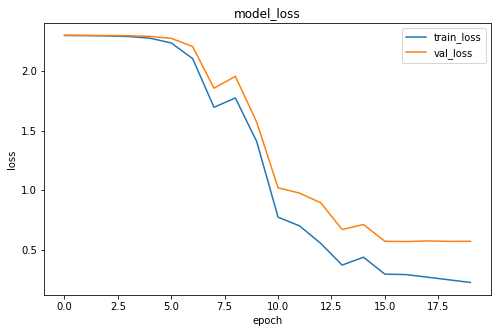

In [15]:
model.plot_learning_curve()